In [6]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/heartbeat/ptbdb_abnormal.csv
/kaggle/input/heartbeat/ptbdb_normal.csv
/kaggle/input/heartbeat/mitbih_test.csv
/kaggle/input/heartbeat/mitbih_train.csv


In [7]:
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as f
from torch.utils.data import DataLoader, Dataset
from tqdm import tqdm

In [8]:
ptbdb_normal = pd.read_csv('/kaggle/input/heartbeat/ptbdb_normal.csv', header = None)
ptbdb_abnormal = pd.read_csv('/kaggle/input/heartbeat/ptbdb_abnormal.csv', header = None)

In [9]:
ptbdb_normal.head()

,0,1,2,3,4,5,6,7,8,9,...,178,179,180,181,182,183,184,185,186,187
0,1.000000,0.900324,0.358590,0.051459,0.046596,0.126823,0.133306,0.119125,0.110616,0.113047,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1.000000,0.794681,0.375387,0.116883,0.000000,0.171923,0.283859,0.293754,0.325912,0.345083,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.909029,0.791482,0.423169,0.186712,0.000000,0.007836,0.063032,0.077002,0.074957,0.077342,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1.000000,0.478893,0.056760,0.064176,0.081289,0.072732,0.055619,0.048774,0.054478,0.041643,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1.000000,0.867238,0.201360,0.099349,0.141336,0.120934,0.108516,0.096393,0.093436,0.100828,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [10]:
df = pd.concat([ptbdb_normal, ptbdb_abnormal])
df.head()

,0,1,2,3,4,5,6,7,8,9,...,178,179,180,181,182,183,184,185,186,187
0,1.000000,0.900324,0.358590,0.051459,0.046596,0.126823,0.133306,0.119125,0.110616,0.113047,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1.000000,0.794681,0.375387,0.116883,0.000000,0.171923,0.283859,0.293754,0.325912,0.345083,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.909029,0.791482,0.423169,0.186712,0.000000,0.007836,0.063032,0.077002,0.074957,0.077342,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1.000000,0.478893,0.056760,0.064176,0.081289,0.072732,0.055619,0.048774,0.054478,0.041643,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1.000000,0.867238,0.201360,0.099349,0.141336,0.120934,0.108516,0.096393,0.093436,0.100828,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


4046
10506


([<matplotlib.axis.XTick at 0x7bfd1dd62b30>,
 [Text(0, 0, '0'), Text(1, 0, '1')])

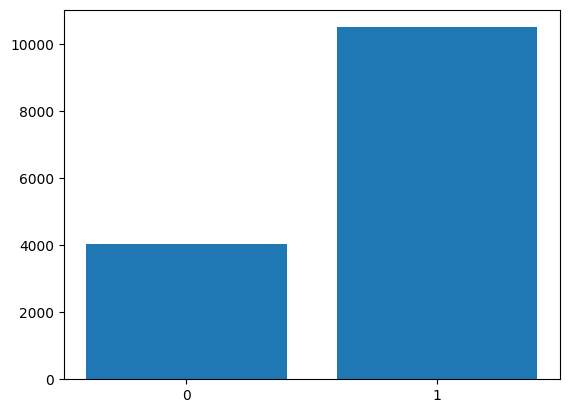

In [11]:
normal_samples = ptbdb_normal.shape[0]
abnormal_samples = ptbdb_abnormal.shape[0]
print(normal_samples)
print(abnormal_samples)
plt.bar((0, 1),(normal_samples, abnormal_samples))
plt.xticks((0, 1))

In [12]:
del ptbdb_normal
del ptbdb_abnormal

In [13]:
class CustomDaggataset(Dataset):
    def __init__(self, df):
        self.df = df
    def __getitem__(self, index):
        X = (torch.FloatTensor(np.array(self.df.iloc[index,:-1]))).unsqueeze(dim=0)
        y = torch.from_numpy((np.array((self.df.iloc[index,-1].astype(int)))))
        return X, y
    def __len__(self):
        return len(self.df[0])

# print(f'X: {X.shape}')
# print(f'y: {y.shape}')

In [14]:
from sklearn.model_selection import train_test_split
X = df.iloc[:,:-1]
y = df.iloc[:,-1]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.1, shuffle = True, random_state = 20, stratify = y)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size = 0.3, shuffle = True, random_state = 20, stratify = y_train)
train_df = pd.DataFrame(np.column_stack((X_train, y_train)))
valid_df = pd.DataFrame(np.column_stack((X_val, y_val)))
test_df = pd.DataFrame(np.column_stack((X_test, y_test)))


In [16]:
class Model(nn.Module):
    def __init__(self):
        super(Model,self).__init__()
        self.cv1d1 = nn.Conv1d(in_channels = 1, out_channels = 3, kernel_size = 32)
        self.cv1d2 = nn.Conv1d(in_channels = 3, out_channels = 10, kernel_size = 16)
        self.cv1d3 = nn.Conv1d(in_channels = 10, out_channels = 10, kernel_size = 8)
        self.mp = nn.MaxPool1d(kernel_size = 2, stride = 2)
        self.fc1 = nn.Linear(120, 30)
        self.fc2 = nn.Linear(30, 10)
        self.fc3 = nn.Linear(10, 2)
    def forward(self, x):
        x = f.relu(self.cv1d1(x))
        x = self.mp(x)
        x = f.relu(self.cv1d2(x))
        x = self.mp(x)
        x = f.relu(self.cv1d3(x))
        x = self.mp(x)
        x = torch.flatten(x, start_dim = 1)
        x = f.relu(self.fc1(x))
        x = f.relu(self.fc2(x))
        x = self.fc3(x)
#         print(x.shape)
        output = f.softmax(x, dim = 1)
        return output

In [17]:
def train(dataloader, model, loss_fn, optimizer):
    model.train()
    losses = np.array([])
    for X, y in tqdm(dataloader):
        # Compute prediction error
        pred = model(X)
        class_pred = torch.argmax(pred, dim = -1)
        loss = loss_fn(pred, y)
        
        # Backpropagation
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        losses = np.append(losses, loss.item())
        
    loss_mean = losses.mean() 
    print(f"loss mean per batch: {loss_mean:>7f}")
    return loss_mean

In [18]:
def validating(dataloader, model, loss_fn):
    
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X, y
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= num_batches
    print(f"Test Error: \n Avg loss per batch: {test_loss:>8f} \n")
    return test_loss

In [19]:
model = Model()

In [20]:
batch_size = 64
train_dataset = CustomDataset(train_df)
val_dataset = CustomDataset(valid_df)
train_loader = DataLoader(train_dataset, batch_size, shuffle = True)
val_loader = DataLoader(val_dataset, batch_size, shuffle = False)
test_loader = DataLoader(val_dataset, 1, shuffle = False)

In [21]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 0.0015)

In [22]:
train_losses = []
val_losses = []
epochs = 150
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_losses.append(train(train_loader, model, criterion, optimizer))
    val_losses.append(validating(val_loader, model, criterion))
#     if t % 10 == 9:
#         plt.plot(np.arange(1, t+2), train_losses)
#         plt.plot(np.arange(1, t+2), val_losses, c = 'red')
#         plt.show()
#         plt.close()
print("Done!")

Epoch 1
-------------------------------


100%|██████████| 144/144 [00:04<00:00, 34.75it/s]


loss mean per batch: 0.589112
Test Error: 
 Avg loss per batch: 0.559874 

Epoch 2
-------------------------------


100%|██████████| 144/144 [00:03<00:00, 40.68it/s]


loss mean per batch: 0.535120
Test Error: 
 Avg loss per batch: 0.516910 

Epoch 3
-------------------------------


100%|██████████| 144/144 [00:03<00:00, 40.38it/s]


loss mean per batch: 0.512187
Test Error: 
 Avg loss per batch: 0.522749 

Epoch 4
-------------------------------


100%|██████████| 144/144 [00:03<00:00, 39.14it/s]


loss mean per batch: 0.505131
Test Error: 
 Avg loss per batch: 0.501794 

Epoch 5
-------------------------------


100%|██████████| 144/144 [00:03<00:00, 39.49it/s]


loss mean per batch: 0.501684
Test Error: 
 Avg loss per batch: 0.499105 

Epoch 6
-------------------------------


100%|██████████| 144/144 [00:03<00:00, 40.50it/s]


loss mean per batch: 0.497713
Test Error: 
 Avg loss per batch: 0.491086 

Epoch 7
-------------------------------


100%|██████████| 144/144 [00:03<00:00, 39.50it/s]


loss mean per batch: 0.493389
Test Error: 
 Avg loss per batch: 0.493648 

Epoch 8
-------------------------------


100%|██████████| 144/144 [00:03<00:00, 40.45it/s]


loss mean per batch: 0.486386
Test Error: 
 Avg loss per batch: 0.481887 

Epoch 9
-------------------------------


100%|██████████| 144/144 [00:03<00:00, 40.38it/s]


loss mean per batch: 0.476421
Test Error: 
 Avg loss per batch: 0.461470 

Epoch 10
-------------------------------


100%|██████████| 144/144 [00:03<00:00, 39.56it/s]


loss mean per batch: 0.463411
Test Error: 
 Avg loss per batch: 0.454817 

Epoch 11
-------------------------------


100%|██████████| 144/144 [00:03<00:00, 38.69it/s]


loss mean per batch: 0.446878
Test Error: 
 Avg loss per batch: 0.446004 

Epoch 12
-------------------------------


100%|██████████| 144/144 [00:03<00:00, 39.63it/s]


loss mean per batch: 0.436669
Test Error: 
 Avg loss per batch: 0.446443 

Epoch 13
-------------------------------


100%|██████████| 144/144 [00:03<00:00, 40.43it/s]


loss mean per batch: 0.433848
Test Error: 
 Avg loss per batch: 0.438183 

Epoch 14
-------------------------------


100%|██████████| 144/144 [00:03<00:00, 36.93it/s]


loss mean per batch: 0.421927
Test Error: 
 Avg loss per batch: 0.419010 

Epoch 15
-------------------------------


100%|██████████| 144/144 [00:03<00:00, 39.98it/s]


loss mean per batch: 0.419565
Test Error: 
 Avg loss per batch: 0.426433 

Epoch 16
-------------------------------


100%|██████████| 144/144 [00:03<00:00, 39.48it/s]


loss mean per batch: 0.412377
Test Error: 
 Avg loss per batch: 0.413998 

Epoch 17
-------------------------------


100%|██████████| 144/144 [00:03<00:00, 39.40it/s]


loss mean per batch: 0.415022
Test Error: 
 Avg loss per batch: 0.417593 

Epoch 18
-------------------------------


100%|██████████| 144/144 [00:03<00:00, 38.86it/s]


loss mean per batch: 0.408614
Test Error: 
 Avg loss per batch: 0.411780 

Epoch 19
-------------------------------


100%|██████████| 144/144 [00:03<00:00, 39.71it/s]


loss mean per batch: 0.408394
Test Error: 
 Avg loss per batch: 0.433017 

Epoch 20
-------------------------------


100%|██████████| 144/144 [00:03<00:00, 38.87it/s]


loss mean per batch: 0.401309
Test Error: 
 Avg loss per batch: 0.401242 

Epoch 21
-------------------------------


100%|██████████| 144/144 [00:03<00:00, 37.77it/s]


loss mean per batch: 0.400425
Test Error: 
 Avg loss per batch: 0.401459 

Epoch 22
-------------------------------


100%|██████████| 144/144 [00:03<00:00, 38.02it/s]


loss mean per batch: 0.397490
Test Error: 
 Avg loss per batch: 0.402073 

Epoch 23
-------------------------------


100%|██████████| 144/144 [00:03<00:00, 38.52it/s]


loss mean per batch: 0.393456
Test Error: 
 Avg loss per batch: 0.397546 

Epoch 24
-------------------------------


100%|██████████| 144/144 [00:03<00:00, 38.57it/s]


loss mean per batch: 0.392426
Test Error: 
 Avg loss per batch: 0.401981 

Epoch 25
-------------------------------


100%|██████████| 144/144 [00:03<00:00, 39.07it/s]


loss mean per batch: 0.393822
Test Error: 
 Avg loss per batch: 0.395550 

Epoch 26
-------------------------------


100%|██████████| 144/144 [00:03<00:00, 37.66it/s]


loss mean per batch: 0.393864
Test Error: 
 Avg loss per batch: 0.393972 

Epoch 27
-------------------------------


100%|██████████| 144/144 [00:04<00:00, 33.75it/s]


loss mean per batch: 0.392208
Test Error: 
 Avg loss per batch: 0.401048 

Epoch 28
-------------------------------


100%|██████████| 144/144 [00:03<00:00, 38.33it/s]


loss mean per batch: 0.388231
Test Error: 
 Avg loss per batch: 0.391232 

Epoch 29
-------------------------------


100%|██████████| 144/144 [00:03<00:00, 39.38it/s]


loss mean per batch: 0.389493
Test Error: 
 Avg loss per batch: 0.396307 

Epoch 30
-------------------------------


100%|██████████| 144/144 [00:03<00:00, 38.54it/s]


loss mean per batch: 0.388112
Test Error: 
 Avg loss per batch: 0.393585 

Epoch 31
-------------------------------


100%|██████████| 144/144 [00:03<00:00, 40.25it/s]


loss mean per batch: 0.389186
Test Error: 
 Avg loss per batch: 0.391208 

Epoch 32
-------------------------------


100%|██████████| 144/144 [00:03<00:00, 38.46it/s]


loss mean per batch: 0.385938
Test Error: 
 Avg loss per batch: 0.387762 

Epoch 33
-------------------------------


100%|██████████| 144/144 [00:03<00:00, 38.57it/s]


loss mean per batch: 0.387191
Test Error: 
 Avg loss per batch: 0.390808 

Epoch 34
-------------------------------


100%|██████████| 144/144 [00:03<00:00, 38.60it/s]


loss mean per batch: 0.386837
Test Error: 
 Avg loss per batch: 0.391881 

Epoch 35
-------------------------------


100%|██████████| 144/144 [00:03<00:00, 38.69it/s]


loss mean per batch: 0.388255
Test Error: 
 Avg loss per batch: 0.389694 

Epoch 36
-------------------------------


100%|██████████| 144/144 [00:03<00:00, 39.60it/s]


loss mean per batch: 0.384452
Test Error: 
 Avg loss per batch: 0.386811 

Epoch 37
-------------------------------


100%|██████████| 144/144 [00:03<00:00, 38.70it/s]


loss mean per batch: 0.384495
Test Error: 
 Avg loss per batch: 0.396507 

Epoch 38
-------------------------------


100%|██████████| 144/144 [00:03<00:00, 38.26it/s]


loss mean per batch: 0.385621
Test Error: 
 Avg loss per batch: 0.386903 

Epoch 39
-------------------------------


100%|██████████| 144/144 [00:03<00:00, 39.79it/s]


loss mean per batch: 0.382749
Test Error: 
 Avg loss per batch: 0.384125 

Epoch 40
-------------------------------


100%|██████████| 144/144 [00:03<00:00, 37.50it/s]


loss mean per batch: 0.389442
Test Error: 
 Avg loss per batch: 0.381286 

Epoch 41
-------------------------------


100%|██████████| 144/144 [00:03<00:00, 38.56it/s]


loss mean per batch: 0.380660
Test Error: 
 Avg loss per batch: 0.382339 

Epoch 42
-------------------------------


100%|██████████| 144/144 [00:03<00:00, 37.33it/s]


loss mean per batch: 0.379164
Test Error: 
 Avg loss per batch: 0.384145 

Epoch 43
-------------------------------


100%|██████████| 144/144 [00:03<00:00, 40.00it/s]


loss mean per batch: 0.377427
Test Error: 
 Avg loss per batch: 0.383357 

Epoch 44
-------------------------------


100%|██████████| 144/144 [00:03<00:00, 38.18it/s]


loss mean per batch: 0.380387
Test Error: 
 Avg loss per batch: 0.385547 

Epoch 45
-------------------------------


100%|██████████| 144/144 [00:03<00:00, 39.30it/s]


loss mean per batch: 0.381372
Test Error: 
 Avg loss per batch: 0.381620 

Epoch 46
-------------------------------


100%|██████████| 144/144 [00:03<00:00, 39.22it/s]


loss mean per batch: 0.377733
Test Error: 
 Avg loss per batch: 0.381608 

Epoch 47
-------------------------------


100%|██████████| 144/144 [00:03<00:00, 39.53it/s]


loss mean per batch: 0.380062
Test Error: 
 Avg loss per batch: 0.388112 

Epoch 48
-------------------------------


100%|██████████| 144/144 [00:03<00:00, 38.04it/s]


loss mean per batch: 0.375435
Test Error: 
 Avg loss per batch: 0.378051 

Epoch 49
-------------------------------


100%|██████████| 144/144 [00:03<00:00, 39.00it/s]


loss mean per batch: 0.383535
Test Error: 
 Avg loss per batch: 0.383657 

Epoch 50
-------------------------------


100%|██████████| 144/144 [00:03<00:00, 39.04it/s]


loss mean per batch: 0.379200
Test Error: 
 Avg loss per batch: 0.382590 

Epoch 51
-------------------------------


100%|██████████| 144/144 [00:03<00:00, 38.05it/s]


loss mean per batch: 0.381174
Test Error: 
 Avg loss per batch: 0.393210 

Epoch 52
-------------------------------


100%|██████████| 144/144 [00:03<00:00, 38.42it/s]


loss mean per batch: 0.378168
Test Error: 
 Avg loss per batch: 0.381006 

Epoch 53
-------------------------------


100%|██████████| 144/144 [00:04<00:00, 34.98it/s]


loss mean per batch: 0.379403
Test Error: 
 Avg loss per batch: 0.383550 

Epoch 54
-------------------------------


100%|██████████| 144/144 [00:03<00:00, 39.30it/s]


loss mean per batch: 0.374011
Test Error: 
 Avg loss per batch: 0.389291 

Epoch 55
-------------------------------


100%|██████████| 144/144 [00:03<00:00, 38.35it/s]


loss mean per batch: 0.374525
Test Error: 
 Avg loss per batch: 0.390418 

Epoch 56
-------------------------------


100%|██████████| 144/144 [00:03<00:00, 39.21it/s]


loss mean per batch: 0.374382
Test Error: 
 Avg loss per batch: 0.395557 

Epoch 57
-------------------------------


100%|██████████| 144/144 [00:03<00:00, 38.62it/s]


loss mean per batch: 0.377524
Test Error: 
 Avg loss per batch: 0.381530 

Epoch 58
-------------------------------


100%|██████████| 144/144 [00:03<00:00, 36.54it/s]


loss mean per batch: 0.381997
Test Error: 
 Avg loss per batch: 0.381513 

Epoch 59
-------------------------------


100%|██████████| 144/144 [00:04<00:00, 35.94it/s]


loss mean per batch: 0.375106
Test Error: 
 Avg loss per batch: 0.384745 

Epoch 60
-------------------------------


100%|██████████| 144/144 [00:03<00:00, 38.49it/s]


loss mean per batch: 0.379773
Test Error: 
 Avg loss per batch: 0.383500 

Epoch 61
-------------------------------


100%|██████████| 144/144 [00:03<00:00, 38.22it/s]


loss mean per batch: 0.375070
Test Error: 
 Avg loss per batch: 0.380665 

Epoch 62
-------------------------------


100%|██████████| 144/144 [00:03<00:00, 37.89it/s]


loss mean per batch: 0.377138
Test Error: 
 Avg loss per batch: 0.381504 

Epoch 63
-------------------------------


100%|██████████| 144/144 [00:03<00:00, 38.26it/s]


loss mean per batch: 0.375329
Test Error: 
 Avg loss per batch: 0.377280 

Epoch 64
-------------------------------


100%|██████████| 144/144 [00:03<00:00, 38.37it/s]


loss mean per batch: 0.373031
Test Error: 
 Avg loss per batch: 0.379683 

Epoch 65
-------------------------------


100%|██████████| 144/144 [00:03<00:00, 39.08it/s]


loss mean per batch: 0.377643
Test Error: 
 Avg loss per batch: 0.381338 

Epoch 66
-------------------------------


100%|██████████| 144/144 [00:03<00:00, 36.03it/s]


loss mean per batch: 0.373713
Test Error: 
 Avg loss per batch: 0.377555 

Epoch 67
-------------------------------


100%|██████████| 144/144 [00:03<00:00, 38.51it/s]


loss mean per batch: 0.371458
Test Error: 
 Avg loss per batch: 0.376461 

Epoch 68
-------------------------------


100%|██████████| 144/144 [00:03<00:00, 39.61it/s]


loss mean per batch: 0.377831
Test Error: 
 Avg loss per batch: 0.375550 

Epoch 69
-------------------------------


100%|██████████| 144/144 [00:03<00:00, 39.16it/s]


loss mean per batch: 0.376698
Test Error: 
 Avg loss per batch: 0.386119 

Epoch 70
-------------------------------


100%|██████████| 144/144 [00:03<00:00, 39.02it/s]


loss mean per batch: 0.373961
Test Error: 
 Avg loss per batch: 0.387552 

Epoch 71
-------------------------------


100%|██████████| 144/144 [00:03<00:00, 38.33it/s]


loss mean per batch: 0.371770
Test Error: 
 Avg loss per batch: 0.378482 

Epoch 72
-------------------------------


100%|██████████| 144/144 [00:03<00:00, 36.29it/s]


loss mean per batch: 0.372545
Test Error: 
 Avg loss per batch: 0.376158 

Epoch 73
-------------------------------


100%|██████████| 144/144 [00:03<00:00, 39.64it/s]


loss mean per batch: 0.374794
Test Error: 
 Avg loss per batch: 0.380864 

Epoch 74
-------------------------------


100%|██████████| 144/144 [00:03<00:00, 38.38it/s]


loss mean per batch: 0.370329
Test Error: 
 Avg loss per batch: 0.381033 

Epoch 75
-------------------------------


100%|██████████| 144/144 [00:03<00:00, 36.57it/s]


loss mean per batch: 0.373149
Test Error: 
 Avg loss per batch: 0.375768 

Epoch 76
-------------------------------


100%|██████████| 144/144 [00:03<00:00, 39.03it/s]


loss mean per batch: 0.371093
Test Error: 
 Avg loss per batch: 0.376838 

Epoch 77
-------------------------------


100%|██████████| 144/144 [00:03<00:00, 37.95it/s]


loss mean per batch: 0.368984
Test Error: 
 Avg loss per batch: 0.376498 

Epoch 78
-------------------------------


100%|██████████| 144/144 [00:03<00:00, 38.92it/s]


loss mean per batch: 0.374559
Test Error: 
 Avg loss per batch: 0.383372 

Epoch 79
-------------------------------


100%|██████████| 144/144 [00:03<00:00, 36.23it/s]


loss mean per batch: 0.367517
Test Error: 
 Avg loss per batch: 0.373199 

Epoch 80
-------------------------------


100%|██████████| 144/144 [00:03<00:00, 38.94it/s]


loss mean per batch: 0.372852
Test Error: 
 Avg loss per batch: 0.377205 

Epoch 81
-------------------------------


100%|██████████| 144/144 [00:03<00:00, 38.75it/s]


loss mean per batch: 0.370037
Test Error: 
 Avg loss per batch: 0.380850 

Epoch 82
-------------------------------


100%|██████████| 144/144 [00:03<00:00, 39.29it/s]


loss mean per batch: 0.369114
Test Error: 
 Avg loss per batch: 0.376990 

Epoch 83
-------------------------------


100%|██████████| 144/144 [00:03<00:00, 37.90it/s]


loss mean per batch: 0.370556
Test Error: 
 Avg loss per batch: 0.383770 

Epoch 84
-------------------------------


100%|██████████| 144/144 [00:03<00:00, 39.23it/s]


loss mean per batch: 0.368137
Test Error: 
 Avg loss per batch: 0.380096 

Epoch 85
-------------------------------


100%|██████████| 144/144 [00:03<00:00, 37.75it/s]


loss mean per batch: 0.370743
Test Error: 
 Avg loss per batch: 0.376099 

Epoch 86
-------------------------------


100%|██████████| 144/144 [00:03<00:00, 39.54it/s]


loss mean per batch: 0.368168
Test Error: 
 Avg loss per batch: 0.382701 

Epoch 87
-------------------------------


100%|██████████| 144/144 [00:03<00:00, 37.70it/s]


loss mean per batch: 0.368497
Test Error: 
 Avg loss per batch: 0.373142 

Epoch 88
-------------------------------


100%|██████████| 144/144 [00:03<00:00, 39.08it/s]


loss mean per batch: 0.365932
Test Error: 
 Avg loss per batch: 0.377602 

Epoch 89
-------------------------------


100%|██████████| 144/144 [00:03<00:00, 38.93it/s]


loss mean per batch: 0.364854
Test Error: 
 Avg loss per batch: 0.378850 

Epoch 90
-------------------------------


100%|██████████| 144/144 [00:04<00:00, 35.44it/s]


loss mean per batch: 0.367073
Test Error: 
 Avg loss per batch: 0.377935 

Epoch 91
-------------------------------


100%|██████████| 144/144 [00:03<00:00, 38.74it/s]


loss mean per batch: 0.363176
Test Error: 
 Avg loss per batch: 0.370437 

Epoch 92
-------------------------------


100%|██████████| 144/144 [00:03<00:00, 38.07it/s]


loss mean per batch: 0.362738
Test Error: 
 Avg loss per batch: 0.370629 

Epoch 93
-------------------------------


100%|██████████| 144/144 [00:03<00:00, 38.90it/s]


loss mean per batch: 0.359581
Test Error: 
 Avg loss per batch: 0.365190 

Epoch 94
-------------------------------


100%|██████████| 144/144 [00:03<00:00, 38.87it/s]


loss mean per batch: 0.355945
Test Error: 
 Avg loss per batch: 0.364900 

Epoch 95
-------------------------------


100%|██████████| 144/144 [00:03<00:00, 37.81it/s]


loss mean per batch: 0.352463
Test Error: 
 Avg loss per batch: 0.364301 

Epoch 96
-------------------------------


100%|██████████| 144/144 [00:03<00:00, 38.46it/s]


loss mean per batch: 0.355573
Test Error: 
 Avg loss per batch: 0.361974 

Epoch 97
-------------------------------


100%|██████████| 144/144 [00:03<00:00, 38.29it/s]


loss mean per batch: 0.352553
Test Error: 
 Avg loss per batch: 0.365017 

Epoch 98
-------------------------------


100%|██████████| 144/144 [00:03<00:00, 37.39it/s]


loss mean per batch: 0.352704
Test Error: 
 Avg loss per batch: 0.370770 

Epoch 99
-------------------------------


100%|██████████| 144/144 [00:03<00:00, 39.16it/s]


loss mean per batch: 0.355079
Test Error: 
 Avg loss per batch: 0.368344 

Epoch 100
-------------------------------


100%|██████████| 144/144 [00:03<00:00, 39.14it/s]


loss mean per batch: 0.353052
Test Error: 
 Avg loss per batch: 0.365809 

Epoch 101
-------------------------------


100%|██████████| 144/144 [00:03<00:00, 39.67it/s]


loss mean per batch: 0.351123
Test Error: 
 Avg loss per batch: 0.360234 

Epoch 102
-------------------------------


100%|██████████| 144/144 [00:03<00:00, 38.45it/s]


loss mean per batch: 0.350638
Test Error: 
 Avg loss per batch: 0.362251 

Epoch 103
-------------------------------


100%|██████████| 144/144 [00:03<00:00, 39.31it/s]


loss mean per batch: 0.360063
Test Error: 
 Avg loss per batch: 0.364145 

Epoch 104
-------------------------------


100%|██████████| 144/144 [00:03<00:00, 38.12it/s]


loss mean per batch: 0.351802
Test Error: 
 Avg loss per batch: 0.359853 

Epoch 105
-------------------------------


100%|██████████| 144/144 [00:03<00:00, 36.97it/s]


loss mean per batch: 0.352375
Test Error: 
 Avg loss per batch: 0.359425 

Epoch 106
-------------------------------


100%|██████████| 144/144 [00:03<00:00, 38.76it/s]


loss mean per batch: 0.349403
Test Error: 
 Avg loss per batch: 0.359676 

Epoch 107
-------------------------------


100%|██████████| 144/144 [00:03<00:00, 38.76it/s]


loss mean per batch: 0.352085
Test Error: 
 Avg loss per batch: 0.360181 

Epoch 108
-------------------------------


100%|██████████| 144/144 [00:03<00:00, 38.71it/s]


loss mean per batch: 0.349761
Test Error: 
 Avg loss per batch: 0.359635 

Epoch 109
-------------------------------


100%|██████████| 144/144 [00:03<00:00, 40.48it/s]


loss mean per batch: 0.348800
Test Error: 
 Avg loss per batch: 0.358992 

Epoch 110
-------------------------------


100%|██████████| 144/144 [00:03<00:00, 39.27it/s]


loss mean per batch: 0.348932
Test Error: 
 Avg loss per batch: 0.360510 

Epoch 111
-------------------------------


100%|██████████| 144/144 [00:03<00:00, 37.49it/s]


loss mean per batch: 0.350329
Test Error: 
 Avg loss per batch: 0.360328 

Epoch 112
-------------------------------


100%|██████████| 144/144 [00:03<00:00, 38.26it/s]


loss mean per batch: 0.353432
Test Error: 
 Avg loss per batch: 0.361364 

Epoch 113
-------------------------------


100%|██████████| 144/144 [00:03<00:00, 39.64it/s]


loss mean per batch: 0.351410
Test Error: 
 Avg loss per batch: 0.363687 

Epoch 114
-------------------------------


100%|██████████| 144/144 [00:03<00:00, 38.68it/s]


loss mean per batch: 0.350109
Test Error: 
 Avg loss per batch: 0.360834 

Epoch 115
-------------------------------


100%|██████████| 144/144 [00:03<00:00, 39.10it/s]


loss mean per batch: 0.350426
Test Error: 
 Avg loss per batch: 0.360015 

Epoch 116
-------------------------------


100%|██████████| 144/144 [00:03<00:00, 36.95it/s]


loss mean per batch: 0.351008
Test Error: 
 Avg loss per batch: 0.360054 

Epoch 117
-------------------------------


100%|██████████| 144/144 [00:03<00:00, 38.78it/s]


loss mean per batch: 0.349444
Test Error: 
 Avg loss per batch: 0.362425 

Epoch 118
-------------------------------


100%|██████████| 144/144 [00:03<00:00, 38.13it/s]


loss mean per batch: 0.347815
Test Error: 
 Avg loss per batch: 0.359384 

Epoch 119
-------------------------------


100%|██████████| 144/144 [00:03<00:00, 38.78it/s]


loss mean per batch: 0.352886
Test Error: 
 Avg loss per batch: 0.359051 

Epoch 120
-------------------------------


100%|██████████| 144/144 [00:03<00:00, 39.14it/s]


loss mean per batch: 0.350796
Test Error: 
 Avg loss per batch: 0.358793 

Epoch 121
-------------------------------


100%|██████████| 144/144 [00:03<00:00, 36.19it/s]


loss mean per batch: 0.349476
Test Error: 
 Avg loss per batch: 0.361140 

Epoch 122
-------------------------------


100%|██████████| 144/144 [00:03<00:00, 38.59it/s]


loss mean per batch: 0.346954
Test Error: 
 Avg loss per batch: 0.357899 

Epoch 123
-------------------------------


100%|██████████| 144/144 [00:03<00:00, 38.43it/s]


loss mean per batch: 0.348906
Test Error: 
 Avg loss per batch: 0.359805 

Epoch 124
-------------------------------


100%|██████████| 144/144 [00:04<00:00, 34.61it/s]


loss mean per batch: 0.351033
Test Error: 
 Avg loss per batch: 0.363294 

Epoch 125
-------------------------------


100%|██████████| 144/144 [00:03<00:00, 38.71it/s]


loss mean per batch: 0.352141
Test Error: 
 Avg loss per batch: 0.360078 

Epoch 126
-------------------------------


100%|██████████| 144/144 [00:03<00:00, 38.42it/s]


loss mean per batch: 0.345290
Test Error: 
 Avg loss per batch: 0.360990 

Epoch 127
-------------------------------


100%|██████████| 144/144 [00:03<00:00, 38.50it/s]


loss mean per batch: 0.345983
Test Error: 
 Avg loss per batch: 0.361254 

Epoch 128
-------------------------------


100%|██████████| 144/144 [00:03<00:00, 38.40it/s]


loss mean per batch: 0.350720
Test Error: 
 Avg loss per batch: 0.361727 

Epoch 129
-------------------------------


100%|██████████| 144/144 [00:03<00:00, 37.93it/s]


loss mean per batch: 0.346222
Test Error: 
 Avg loss per batch: 0.360339 

Epoch 130
-------------------------------


100%|██████████| 144/144 [00:03<00:00, 38.35it/s]


loss mean per batch: 0.346840
Test Error: 
 Avg loss per batch: 0.359509 

Epoch 131
-------------------------------


100%|██████████| 144/144 [00:03<00:00, 39.02it/s]


loss mean per batch: 0.349170
Test Error: 
 Avg loss per batch: 0.357043 

Epoch 132
-------------------------------


100%|██████████| 144/144 [00:03<00:00, 39.07it/s]


loss mean per batch: 0.348871
Test Error: 
 Avg loss per batch: 0.360326 

Epoch 133
-------------------------------


100%|██████████| 144/144 [00:03<00:00, 38.20it/s]


loss mean per batch: 0.348768
Test Error: 
 Avg loss per batch: 0.360259 

Epoch 134
-------------------------------


100%|██████████| 144/144 [00:03<00:00, 38.24it/s]


loss mean per batch: 0.348054
Test Error: 
 Avg loss per batch: 0.361871 

Epoch 135
-------------------------------


100%|██████████| 144/144 [00:03<00:00, 37.79it/s]


loss mean per batch: 0.344897
Test Error: 
 Avg loss per batch: 0.356937 

Epoch 136
-------------------------------


100%|██████████| 144/144 [00:03<00:00, 38.26it/s]


loss mean per batch: 0.344417
Test Error: 
 Avg loss per batch: 0.357107 

Epoch 137
-------------------------------


100%|██████████| 144/144 [00:03<00:00, 36.58it/s]


loss mean per batch: 0.344651
Test Error: 
 Avg loss per batch: 0.358477 

Epoch 138
-------------------------------


100%|██████████| 144/144 [00:03<00:00, 38.36it/s]


loss mean per batch: 0.345490
Test Error: 
 Avg loss per batch: 0.363500 

Epoch 139
-------------------------------


100%|██████████| 144/144 [00:03<00:00, 37.82it/s]


loss mean per batch: 0.345682
Test Error: 
 Avg loss per batch: 0.355117 

Epoch 140
-------------------------------


100%|██████████| 144/144 [00:03<00:00, 37.34it/s]


loss mean per batch: 0.348219
Test Error: 
 Avg loss per batch: 0.361677 

Epoch 141
-------------------------------


100%|██████████| 144/144 [00:03<00:00, 38.04it/s]


loss mean per batch: 0.346902
Test Error: 
 Avg loss per batch: 0.356076 

Epoch 142
-------------------------------


100%|██████████| 144/144 [00:04<00:00, 35.36it/s]


loss mean per batch: 0.355973
Test Error: 
 Avg loss per batch: 0.361008 

Epoch 143
-------------------------------


100%|██████████| 144/144 [00:03<00:00, 36.11it/s]


loss mean per batch: 0.346444
Test Error: 
 Avg loss per batch: 0.357240 

Epoch 144
-------------------------------


100%|██████████| 144/144 [00:03<00:00, 38.96it/s]


loss mean per batch: 0.351511
Test Error: 
 Avg loss per batch: 0.357845 

Epoch 145
-------------------------------


100%|██████████| 144/144 [00:03<00:00, 37.98it/s]


loss mean per batch: 0.345444
Test Error: 
 Avg loss per batch: 0.355745 

Epoch 146
-------------------------------


100%|██████████| 144/144 [00:03<00:00, 37.87it/s]


loss mean per batch: 0.347270
Test Error: 
 Avg loss per batch: 0.358484 

Epoch 147
-------------------------------


100%|██████████| 144/144 [00:03<00:00, 38.38it/s]


loss mean per batch: 0.351315
Test Error: 
 Avg loss per batch: 0.386725 

Epoch 148
-------------------------------


100%|██████████| 144/144 [00:04<00:00, 35.97it/s]


loss mean per batch: 0.346653
Test Error: 
 Avg loss per batch: 0.356741 

Epoch 149
-------------------------------


100%|██████████| 144/144 [00:03<00:00, 39.03it/s]


loss mean per batch: 0.343997
Test Error: 
 Avg loss per batch: 0.357447 

Epoch 150
-------------------------------


100%|██████████| 144/144 [00:03<00:00, 37.98it/s]


loss mean per batch: 0.349122
Test Error: 
 Avg loss per batch: 0.358346 

Done!


In [ ]:
y_pred

0.9541868159837109


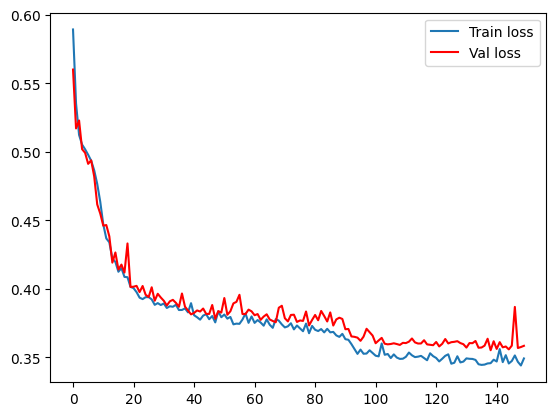

In [25]:
plt.plot(train_losses, label = "Train loss")
plt.plot(val_losses, c = 'red', label = "Val loss")
plt.legend()

from sklearn.metrics import accuracy_score, precision_score, recall_score
model.eval()
output_pred = torch.cat([model(i) for i, _ in test_loader])
y_test = torch.cat([i for _, i in test_loader])
y_pred = torch.argmax(output_pred, dim = -1)
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
print(accuracy)

In [26]:
print(precision)
print(recall)

0.9640237513098149
0.9728586535072259


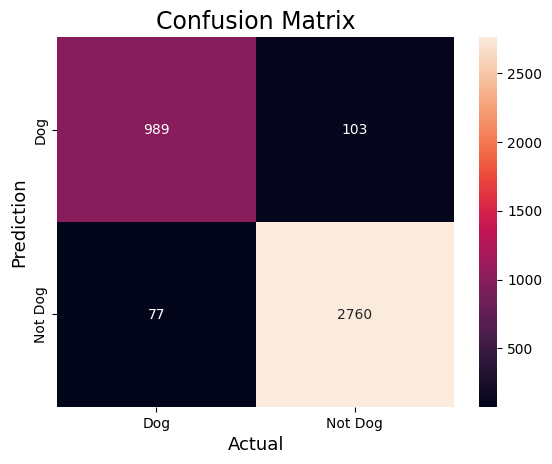

In [27]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
   
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, 
            annot=True,
            fmt='g', 
            xticklabels=['Dog','Not Dog'],
            yticklabels=['Dog','Not Dog'])
plt.ylabel('Prediction',fontsize=13)
plt.xlabel('Actual',fontsize=13)
plt.title('Confusion Matrix',fontsize=17)
plt.show()